# Imports

In [1]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [ ]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'zscore_score',
   'zscore_round_duration',
   'zscore_efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   'ort_img',
   'rep_man',
   'soc_pers',
   'team_size',
   'difficulty',
   'score',
   'duration',
   'efficiency',
   'timestamp']},
 'dat': {'filename': 'DAT_output_conversation_level.csv',
  'cols_to_ignore':

# Repeated k-Fold Cross-Validation

In [ ]:
def repeated_kfold_cv(model, k = 10, seed = 19104):

    """
    Parameters:
    - model: The model we are doing k-fold CV for
    - k: the number of fols (defaults to 10)
    - seed: the random seed (defaults to 19104)

    @returns the following, pouplated with data from the k0=-fold CV:
    - train_metrics: a dataframe to store all the training metrics
    - test_metrics: a dataframe to store all the test set metrics (we will universally use a 80-20 train-test split)
    - shap_df: a dataframe to store the Shapley value summaries for each fold
    - shap_correlation_df: a dataframe to store how the Shapley values correlate with feature values for each fold
    """

    # Repeated k-fold cross-validation
    random.seed(seed) # set seed for reproducibility
    random_states_list = [random.randint(100, 1000000) for _ in range(k)] # create a bunch of different random states

    # Store metrics --- R^2, MAE, MSE
    metrics = ['r2', 'mae', 'mse', 'rmse']
    train_metrics = pd.DataFrame(columns=metrics)
    test_metrics = pd.DataFrame(columns=metrics)

    for i in range(len(random_states_list)):
        # store the model metrics for each iteration
        metrics = model.evaluate_model(model.baseline_model, val_size = 0.2, test_size = None, random_state = random_states_list[i], visualize_model = False)
        train_metrics = train_metrics.append(metrics['train'], ignore_index=True)
        test_metrics = test_metrics.append(metrics['val'], ignore_index=True)
    
        # store the shap summary for each iteration

        try:     
            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)
        except NameError:
            # we haven't defined these yet; we're in the first iteration!
            # we have to do this becaus model.X does not show up until after the first case when evaluate_model is called
            shap_df = pd.DataFrame({'feature': model.X.columns})
            shap_correlation_df = pd.DataFrame({'feature': model.X.columns})

            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)


    shap_df.set_index('feature', inplace=True)
    shap_correlation_df.set_index('feature', inplace=True)

    return(shap_df, shap_correlation_df, train_metrics, test_metrics)

In [ ]:
def get_repeated_kfold_cv_summary(shap_df, shap_correlation_df, train_metrics, test_metrics):
    """
    Get the means of the repeated k-fold cross validation across all relevant metrics.
    """
    shap_means = shap_df.mean(axis=1).sort_values(ascending = False)
    shap_cor_means = shap_correlation_df.mean(axis=1).reindex(index = shap_means.index)
    train_means = train_metrics.mean()
    test_means = test_metrics.mean()

    return(shap_means, shap_cor_means, train_means, test_means)

In [ ]:
time_points = ["25% of data", "50% of data", "75% of data", "100% of data"]

In [ ]:
NUM_TOP_FEATURES = 3

In [ ]:
def plot_important_features_over_time(merged_df, color_palette, title="Top Feature Importance Over Time", filename="./figures/feature_importance.png"):
    # Transpose the DataFrame and sort by each time point
    top_features = merged_df.apply(lambda x: x.nlargest(NUM_TOP_FEATURES))

    non_na_feature = top_features.dropna()
    na_feature = top_features.loc[~top_features.index.isin(top_features.dropna().index)].fillna(0)

    # Plot a line chart to show how the top feature values change over time
    if not non_na_feature.empty:
        ax = non_na_feature.T.plot(kind='line', marker='o', linewidth=3, color=color_palette)
        na_feature.T.plot(kind='line', marker='o', linestyle='--', linewidth=3, ax=ax, color=color_palette)  # Use the same axis for dashed lines
    else:
        ax = na_feature.T.plot(kind='line', marker='o', linestyle='--', linewidth=3, color=color_palette)

    plt.ylabel('Importance (SHAP value)', size=14)
    plt.title(title, fontsize=18, fontweight="bold")
    plt.xticks(range(len(time_points)), time_points, fontsize=14)

    # Update legend with custom color mapping
    legend_labels = ax.get_legend().get_texts()
    for label in legend_labels:
        feature_name = label.get_text()

    plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1.05, 1), bbox_transform=ax.transAxes)

    plt.savefig(filename, dpi=1200, bbox_inches='tight')
    plt.show()

# Multi-Task Joint Model

### Joint Model (standardizing features _across_ tasks)

In [ ]:
joint_model = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "dat"])
joint_model.select_target(target=["majority_pct", "zscore_efficiency", "efficiency", "mean_post_discussion_error_pct", "score"])
joint_model.define_model(model_type = 'rf')

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


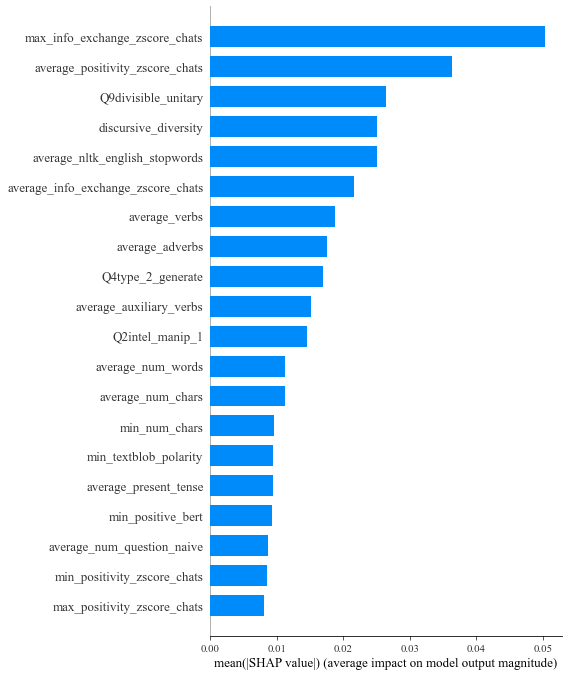

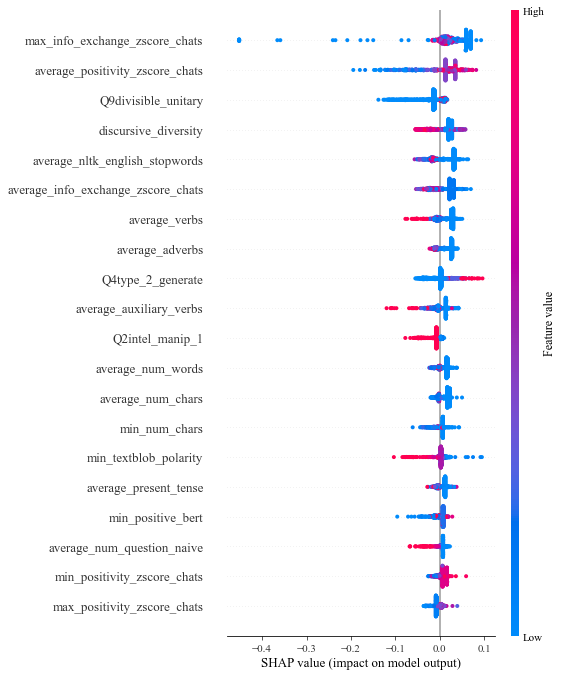

MODEL METRICS
Train Set:	R2: 0.4442	MAE: 0.4871	MSE: 0.5406	RMSE: 0.7353
Validation Set:	R2: 0.1058	MAE: 0.695	MSE: 0.9967	RMSE: 0.9983
Test Set:	R2: 0.1796	MAE: 0.6703	MSE: 0.8049	RMSE: 0.8972


{'train': {'r2': 0.4442, 'mae': 0.4871, 'mse': 0.5406, 'rmse': 0.7353},
 'val': {'r2': 0.1058, 'mae': 0.695, 'mse': 0.9967, 'rmse': 0.9983},
 'test': {'r2': 0.1796, 'mae': 0.6703, 'mse': 0.8049, 'rmse': 0.8972}}

In [ ]:
joint_model.evaluate_model(joint_model.baseline_model, val_size = 0.2)

In [9]:
# Call the Repeated k-Fold CV
joint_shap, joint_shap_cor, joint_train_metrics, joint_test_metrics = repeated_kfold_cv(joint_model)
joint_shap_means, joint_shap_cor_means, joint_train_means, joint_test_means = get_repeated_kfold_cv_summary(joint_shap, joint_shap_cor, joint_train_metrics, joint_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


In [11]:
joint_shap_means

feature
average_nltk_english_stopwords    0.087489
average_num_chars                 0.053006
average_num_words                 0.041496
average_auxiliary_verbs           0.038730
max_info_exchange_zscore_chats    0.036116
                                    ...   
min_death                         0.000000
min_apologizing                   0.000000
min_indirect_(btw)                0.000000
stdev_indirect_(btw)              0.000000
min_subjunctive                   0.000000
Length: 414, dtype: float64

80% data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.4643	MAE: 0.484	MSE: 0.544	RMSE: 0.7376
Validation Set:	R2: 0.1506	MAE: 0.6755	MSE: 0.7943	RMSE: 0.8912


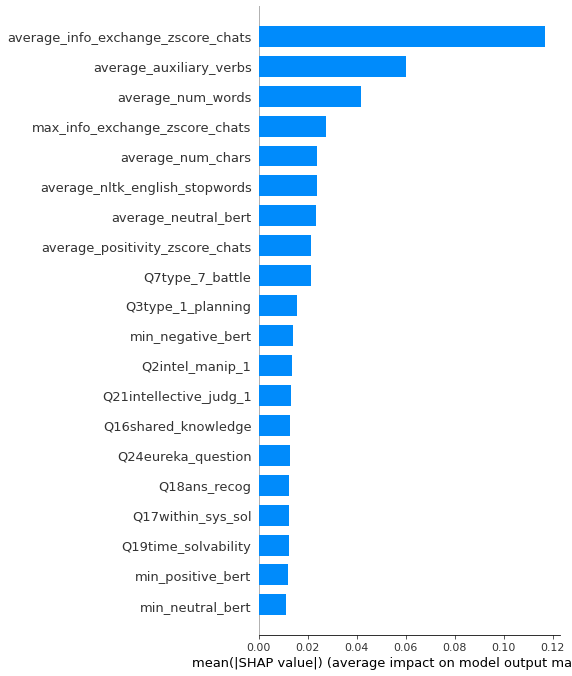

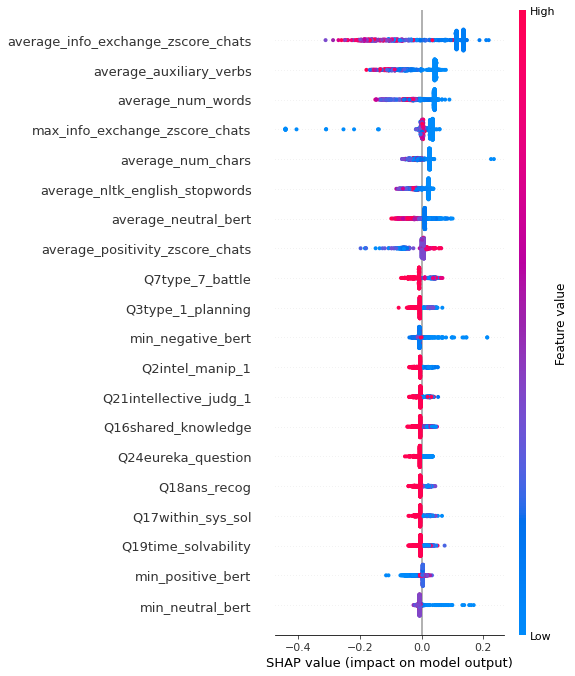

In [4]:
joint_model80 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "dat"], output_dir = '../output/first_80/')
joint_model80.select_target(target=["majority_pct", "zscore_efficiency", "efficiency", "mean_post_discussion_error_pct", "score"])
joint_model80.define_model(model_type = 'rf')
joint_model80.evaluate_model(joint_model80.baseline_model, val_size = 0.2, test_size = None)

50% data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.4624	MAE: 0.4861	MSE: 0.5459	RMSE: 0.7389
Validation Set:	R2: 0.1497	MAE: 0.6792	MSE: 0.7951	RMSE: 0.8917


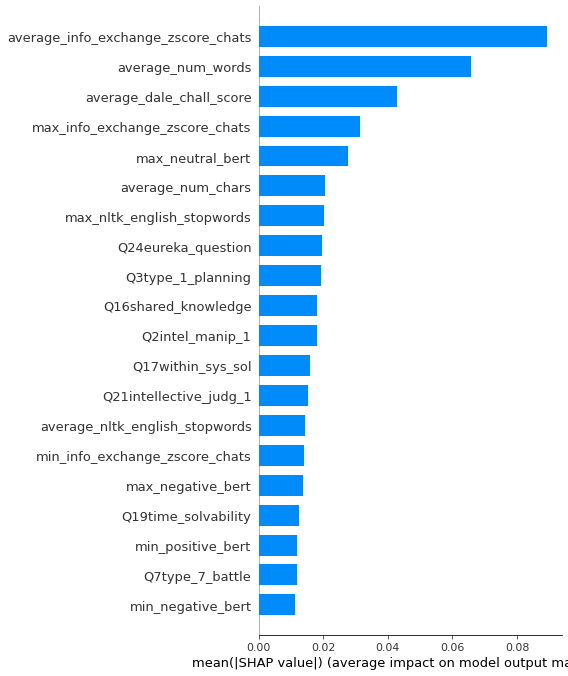

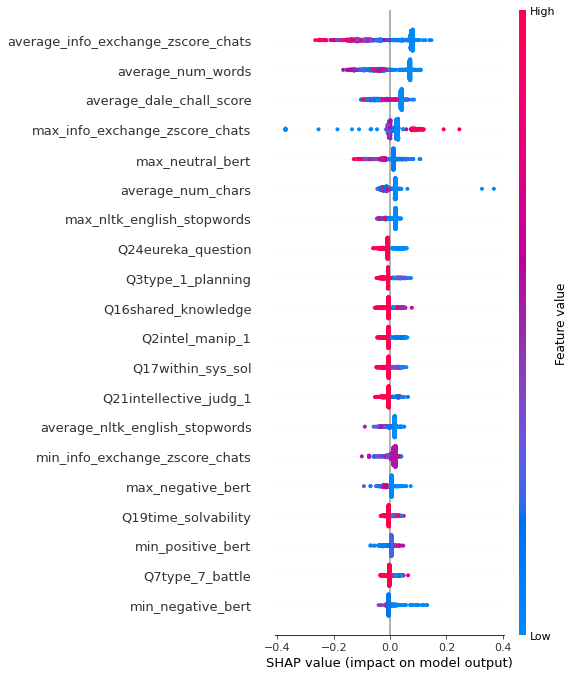

In [5]:
joint_model50 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "dat"], output_dir = '../output/first_50/')
joint_model50.select_target(target=["majority_pct", "zscore_efficiency", "efficiency", "mean_post_discussion_error_pct", "score"])
joint_model50.define_model(model_type = 'rf')
joint_model50.evaluate_model(joint_model50.baseline_model, val_size = 0.2, test_size = None)

### Joint Model (standardizing features _between_ tasks)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.4634	MAE: 0.4847	MSE: 0.5449	RMSE: 0.7382
Validation Set:	R2: 0.1808	MAE: 0.6606	MSE: 0.766	RMSE: 0.8752


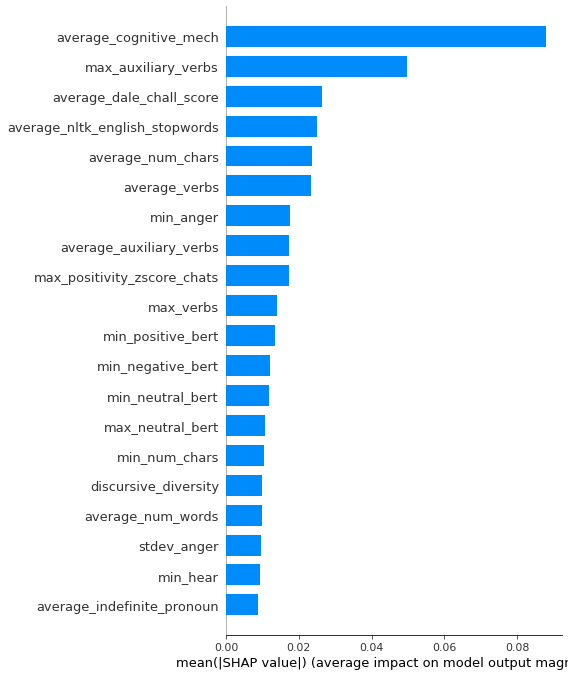

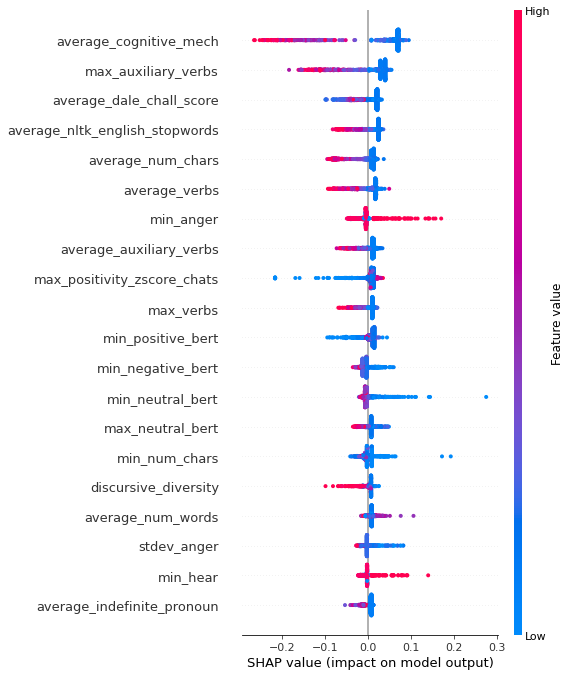

In [6]:
# standardize_within defaults to false, so let's check what happens when we change it to true
joint_model_std_within = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "dat"], standardize_within= True)
joint_model_std_within.select_target(target=["majority_pct", "zscore_efficiency", "efficiency", "mean_post_discussion_error_pct", "score"])
joint_model_std_within.define_model(model_type = 'rf')
joint_model_std_within.evaluate_model(joint_model_std_within.baseline_model, val_size = 0.2, test_size = None)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.4641	MAE: 0.4842	MSE: 0.5442	RMSE: 0.7377
Validation Set:	R2: 0.1674	MAE: 0.6676	MSE: 0.7785	RMSE: 0.8823


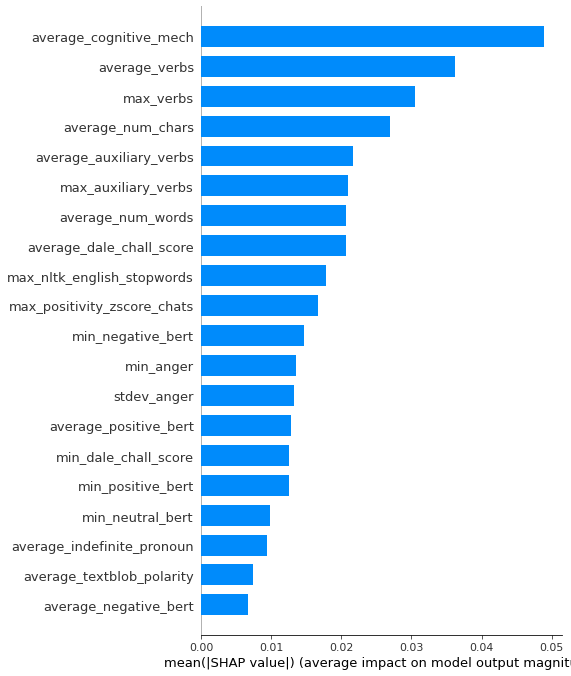

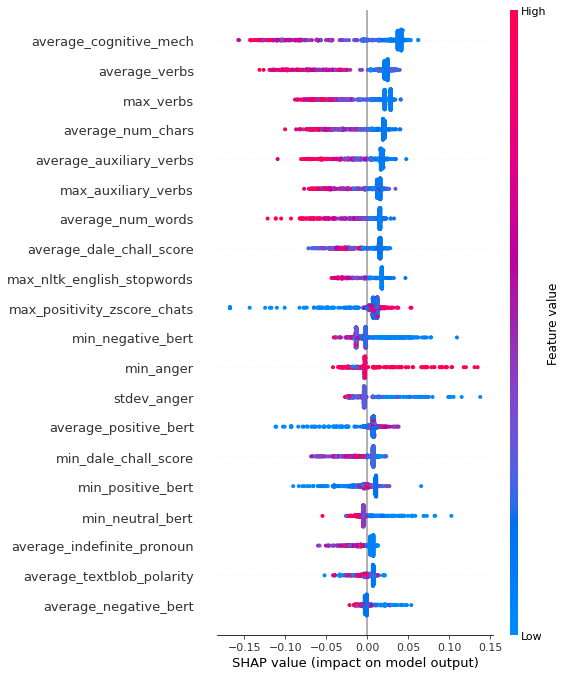

In [7]:
joint_model_std_within80 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "dat"], standardize_within= True, output_dir = '../output/first_80/')
joint_model_std_within80.select_target(target=["majority_pct", "zscore_efficiency", "efficiency", "mean_post_discussion_error_pct", "score"])
joint_model_std_within80.define_model(model_type = 'rf')
joint_model_std_within80.evaluate_model(joint_model_std_within80.baseline_model, val_size = 0.2, test_size = None)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.4633	MAE: 0.4843	MSE: 0.5451	RMSE: 0.7383
Validation Set:	R2: 0.163	MAE: 0.6711	MSE: 0.7826	RMSE: 0.8846


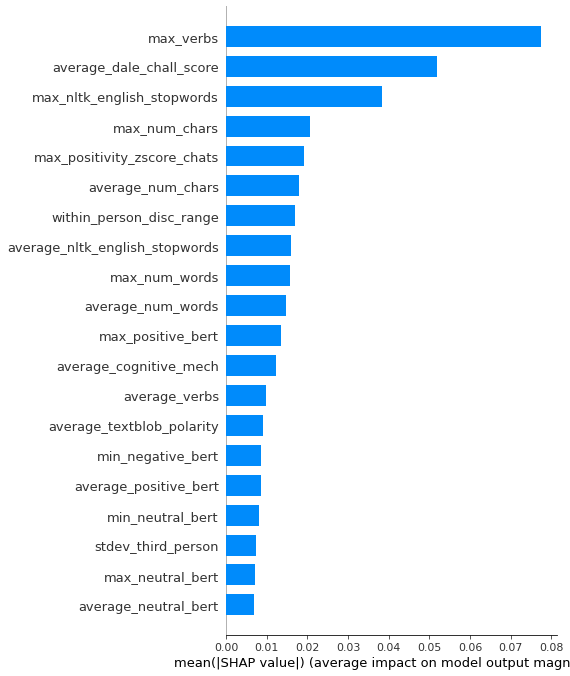

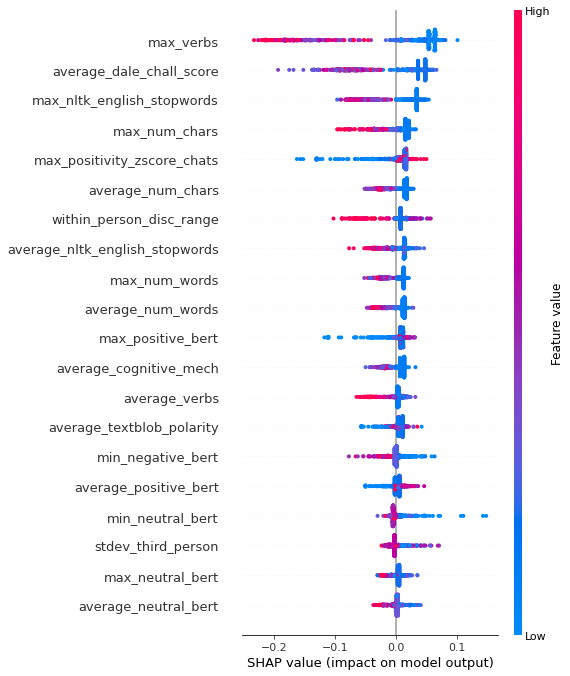

In [8]:
joint_model_std_within50 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "dat"], standardize_within= True, output_dir = '../output/first_50/')
joint_model_std_within50.select_target(target=["majority_pct", "zscore_efficiency", "efficiency", "mean_post_discussion_error_pct", "score"])
joint_model_std_within50.define_model(model_type = 'rf')
joint_model_std_within50.evaluate_model(joint_model_std_within50.baseline_model, val_size = 0.2, test_size = None)